In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

## 2002 统计分析

In [2]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_02(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata02 = pd.read_csv("perlist02_h.csv")
    f = perdata02['f']
    per = perdata02['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata02)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [3]:
m02=Minuit(twi_minus_loglikelihood_02,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=10,poisson=50,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,0), limit_log_f_b=(-7,-2),limit_alpha_H=(1.0,100.0),limit_poisson=(0,100),
         errordef=1)

m02.migrad()

pprint(m02.fval)

FCN = 7870.458956781781 
 TOTAL NCALL = 247 
 NCALLS = 247 
 
 
 EDM = 3.8773167826769475e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.40365,0.101894,,,-3,0,No
1,log_f_b,-3.29969,0.0109779,,,-7,-2,No
2,alpha_H,100,90.6666,,,1,100,No
3,poisson,74.8644,2.83596,,,0,100,No


7870.458956781781


In [4]:
perdata02 = pd.read_csv("perlist02_h.csv")
f_02 = perdata02['f']
per_02 = perdata02['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m02.values[0],m02.values[1],m02.values[2],m02.values[3]

model_02 = []
R_obs_02 = []
T_SSE_obs_02 = 0
f_length_02 = len(f_02)
for i in range(f_length_02):
    model_02.append(((f_02[i]**(-alpha_L))/(1+(f_02[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_02.append(2*per_02[i]/model_02[i])
    T_SSE_obs_02 += (((per_02[i]-model_02[i])/model_02[i])**2)
    
# 两个统计量
T_R_obs_02 = max(R_obs_02)
print ("T_R =", T_R_obs_02)
print ("T_SSE =", T_SSE_obs_02)

T_R = 12.507866537904874
T_SSE = 715.9399155917444


In [5]:
# 5000条光变曲线

df = 0.01/f_length_02
N = 2*f_length_02
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_02]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_02):
        R_simu.append(2*per_simu[i]/model_02[i])
        T_SSE_simu += (((per_simu[i]-model_02[i])/model_02[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_02:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_02:
        n_TSSE += 1

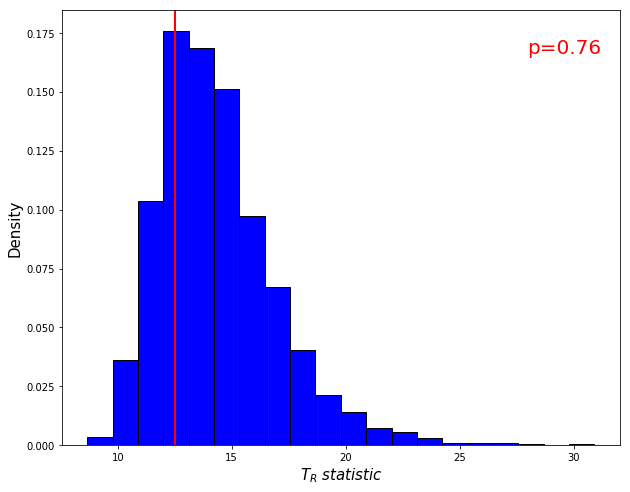

In [6]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_02, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

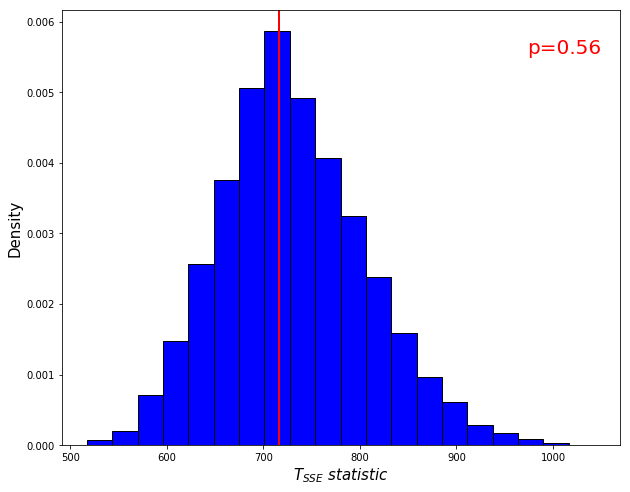

In [7]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_02, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2008(1) 统计分析

In [8]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_081(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata081 = pd.read_csv("perlist081_h.csv")
    f = perdata081['f']
    per = perdata081['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata081)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [9]:
m081=Minuit(twi_minus_loglikelihood_081,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

m081.migrad()

pprint(m081.fval)

FCN = 8873.095538201815 
 TOTAL NCALL = 270 
 NCALLS = 270 
 
 
 EDM = 1.3725634822725776e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1,0.000257848,,,-3,-1,No
1,log_f_b,-2,0.000245765,,,-5,-2,No
2,alpha_H,5,0.0125969,,,1,5,No
3,poisson,2,0.00529517,,,0,2,No


8873.095538201815


In [10]:
perdata081 = pd.read_csv("perlist081_h.csv")
f_081 = perdata081['f']
per_081 = perdata081['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m081.values[0],m081.values[1],m081.values[2],m081.values[3]

model_081 = []
R_obs_081 = []
T_SSE_obs_081 = 0
f_length_081 = len(f_081)
for i in range(f_length_081):
    model_081.append(((f_081[i]**(-alpha_L))/(1+(f_081[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_081.append(2*per_081[i]/model_081[i])
    T_SSE_obs_081 += (((per_081[i]-model_081[i])/model_081[i])**2)
    
# 两个统计量
T_R_obs_081 = max(R_obs_081)
print ("T_R =", T_R_obs_081)
print ("T_SSE =", T_SSE_obs_081)

T_R = 50.26934415181013
T_SSE = 7618.0307696425325


In [11]:
# 5000条光变曲线

df = 0.01/f_length_081
N = 2*f_length_081
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_081]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_081):
        R_simu.append(2*per_simu[i]/model_081[i])
        T_SSE_simu += (((per_simu[i]-model_081[i])/model_081[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_081:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_081:
        n_TSSE += 1

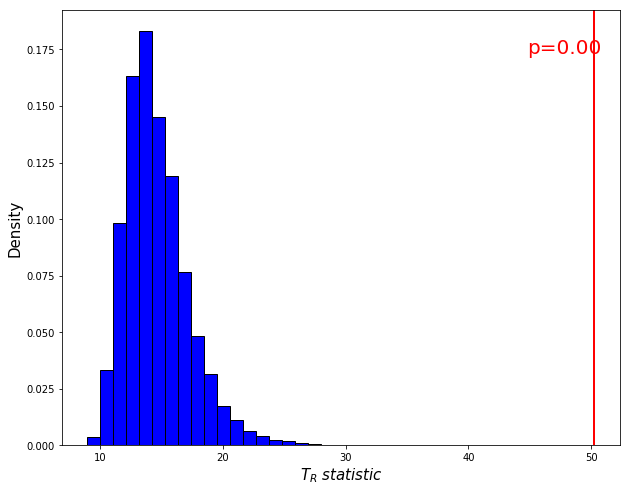

In [12]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_081, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

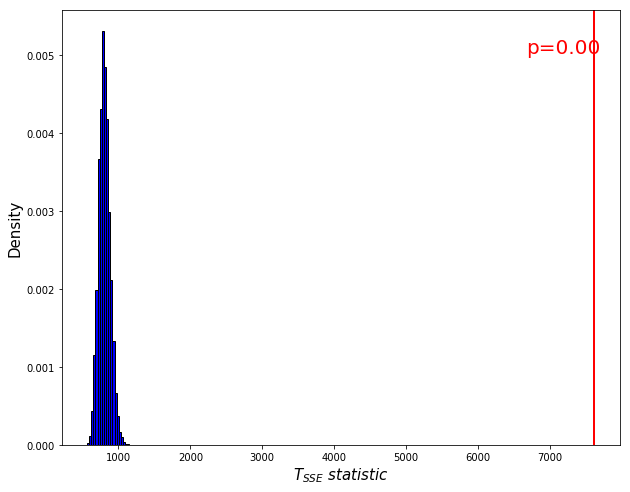

In [13]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_081, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2010(1) 统计分析

In [14]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_101(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata101 = pd.read_csv("perlist101_h.csv")
    f = perdata101['f']
    per = perdata101['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata101)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [15]:
m101=Minuit(twi_minus_loglikelihood_101,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,0), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,5),
         errordef=1)

m101.migrad()

pprint(m101.fval)

FCN = 11733.93897559632 
 TOTAL NCALL = 275 
 NCALLS = 275 
 
 
 EDM = 4.730987538991465e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-0.0481894,0.0147208,,,-3,0,No
1,log_f_b,-2.24734,2.76212,,,-5,-2,No
2,alpha_H,1,0.00231339,,,1,5,No
3,poisson,5,0.146546,,,0,5,No


11733.93897559632


In [16]:
perdata101 = pd.read_csv("perlist101_h.csv")
f_101 = perdata101['f']
per_101 = perdata101['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m101.values[0],m101.values[1],m101.values[2],m101.values[3]

model_101 = []
R_obs_101 = []
T_SSE_obs_101 = 0
f_length_101 = len(f_101)
for i in range(f_length_101):
    model_101.append(((f_101[i]**(-alpha_L))/(1+(f_101[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_101.append(2*per_101[i]/model_101[i])
    T_SSE_obs_101 += (((per_101[i]-model_101[i])/model_101[i])**2)
    
# 两个统计量
T_R_obs_101 = max(R_obs_101)
print ("T_R =", T_R_obs_101)
print ("T_SSE =", T_SSE_obs_101)

T_R = 34.06508370598787
T_SSE = 1835.7588157887778


In [17]:
# 5000条光变曲线

df = 0.01/f_length_101
N = 2*f_length_101
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_101]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_101):
        R_simu.append(2*per_simu[i]/model_101[i])
        T_SSE_simu += (((per_simu[i]-model_101[i])/model_101[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_101:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_101:
        n_TSSE += 1

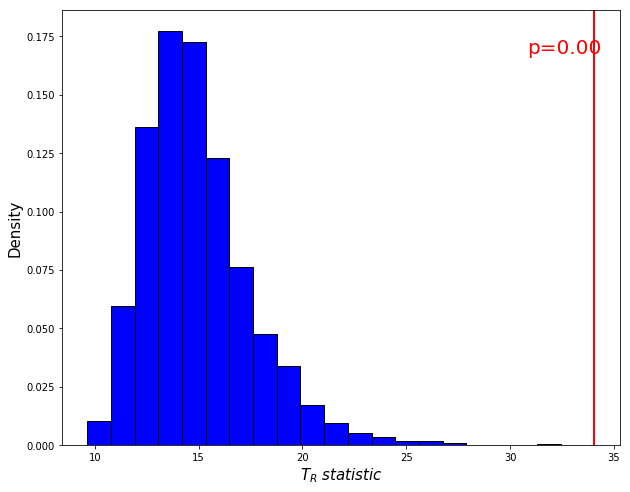

In [18]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_101, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

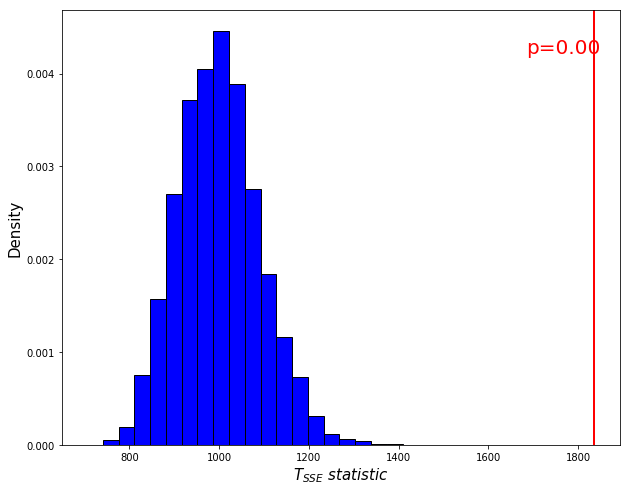

In [19]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_101, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2007(2) 统计分析

In [20]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_072(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata072 = pd.read_csv("perlist072_h.csv")
    f = perdata072['f']
    per = perdata072['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata072)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [21]:
m072=Minuit(twi_minus_loglikelihood_072,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,0), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,5),
         errordef=1)

m072.migrad()

pprint(m072.fval)

FCN = 4442.574578678197 
 TOTAL NCALL = 203 
 NCALLS = 203 
 
 
 EDM = 0.0001384038477495913 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-0.104059,0.0238224,,,-3,0,No
1,log_f_b,-2.0494,2.48809,,,-5,-2,No
2,alpha_H,1,0.00658777,,,1,5,No
3,poisson,4.99996,0.388057,,,0,5,No


4442.574578678197


In [22]:
perdata072 = pd.read_csv("perlist072_s.csv")
f_072 = perdata072['f']
per_072 = perdata072['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m072.values[0],m072.values[1],m072.values[2],m072.values[3]

model_072 = []
R_obs_072 = []
T_SSE_obs_072 = 0
f_length_072 = len(f_072)
for i in range(f_length_072):
    model_072.append(((f_072[i]**(-alpha_L))/(1+(f_072[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_072.append(2*per_072[i]/model_072[i])
    T_SSE_obs_072 += (((per_072[i]-model_072[i])/model_072[i])**2)
    
# 两个统计量
T_R_obs_072 = max(R_obs_072)
print ("T_R =", T_R_obs_072)
print ("T_SSE =", T_SSE_obs_072)

T_R = 1.6049236803429647
T_SSE = 347.8729224990584


In [23]:
# 5000条光变曲线

df = 0.01/f_length_072
N = 2*f_length_072
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_072]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_072):
        R_simu.append(2*per_simu[i]/model_072[i])
        T_SSE_simu += (((per_simu[i]-model_072[i])/model_072[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_072:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_072:
        n_TSSE += 1

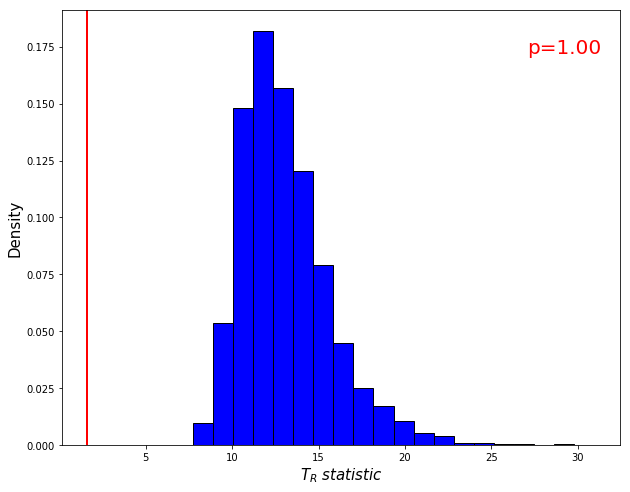

In [24]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_072, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

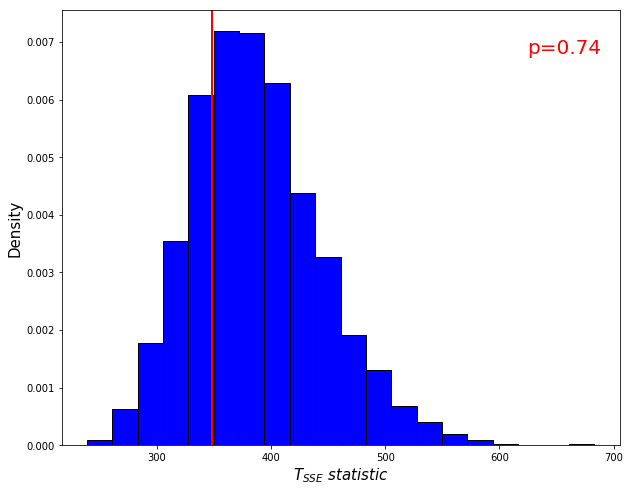

In [25]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_072, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 综合结果

In [26]:
data02 = pd.read_csv("energy_1h0707_02.csv")  
x02 = data02['x']
y02 = data02['y']
xerr02 = data02['xerr']
yerr02 = data02['yerr']

data081 = pd.read_csv("energy_1h0707_081.csv")  
x081 = data081['x']
y081 = data081['y']
xerr081 = data081['xerr']
yerr081 = data081['yerr']

data101 = pd.read_csv("energy_1h0707_101.csv")  
x101 = data101['x']
y101 = data101['y']
xerr101 = data101['xerr']
yerr101 = data101['yerr']

data072 = pd.read_csv("energy_1h0707_072.csv")  
x072 = data072['x']
y072 = data072['y']
xerr072 = data072['xerr']
yerr072 = data072['yerr']

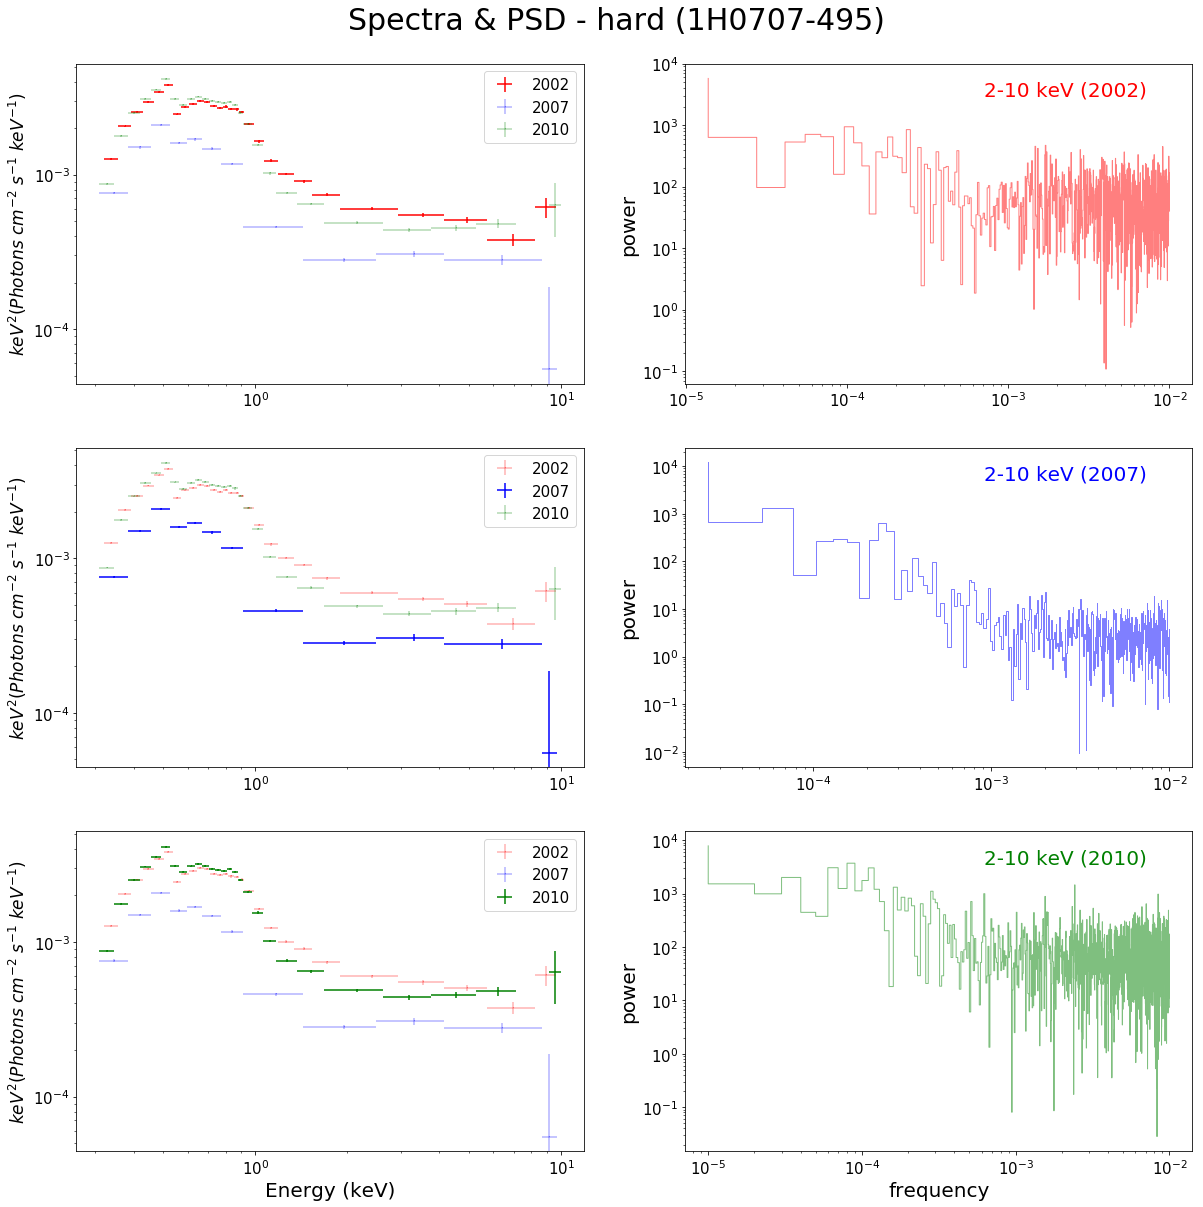

In [27]:
fig= plt.figure(figsize=(20,20))
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)



ax1.loglog()
ax1.errorbar(x02, y02, yerr=yerr02, xerr=xerr02, fmt=',r', label='2002')
ax1.errorbar(x072, y072, yerr=yerr072, xerr=xerr072, fmt=',b', alpha=0.3, label='2007')
ax1.errorbar(x101, y101, yerr=yerr101, xerr=xerr101, fmt=',g', alpha=0.3, label='2010')
#ax1.set_xlabel("Energy (keV)",fontsize=20)
ax1.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)

ax3.loglog()
ax3.errorbar(x02, y02, yerr=yerr02, xerr=xerr02, fmt=',r', alpha=0.3, label='2002')
ax3.errorbar(x072, y072, yerr=yerr072, xerr=xerr072, fmt=',b', label='2007')
ax3.errorbar(x101, y101, yerr=yerr101, xerr=xerr101, fmt=',g', alpha=0.3, label='2010')
#ax3.set_xlabel("Energy (keV)",fontsize=20)
ax3.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax3.legend(fontsize=15)
ax3.tick_params(labelsize=15)

ax5.loglog()
ax5.errorbar(x02, y02, yerr=yerr02, xerr=xerr02, fmt=',r', alpha=0.3, label='2002')
ax5.errorbar(x072, y072, yerr=yerr072, xerr=xerr072, fmt=',b', alpha=0.3, label='2007')
ax5.errorbar(x101, y101, yerr=yerr101, xerr=xerr101, fmt=',g', label='2010')
ax5.set_xlabel("Energy (keV)",fontsize=20)
ax5.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax5.legend(fontsize=15)
ax5.tick_params(labelsize=15)


ax2.loglog()
ax2.step(f_02, per_02, color="r", alpha=0.5, linewidth=1)
#ax2.plot(f_02, model_02, color="r", linewidth=1)
#ax2.set_xlabel("frequency",fontsize=20)
ax2.set_ylabel("power",fontsize=20)
ax2.text(0.75,0.9,"2-10 keV (2002)",color='r',ha='center',transform=ax2.transAxes,fontsize=20)
ax2.tick_params(labelsize=15)

ax4.loglog()
ax4.step(f_072, per_072, color="b", alpha=0.5, linewidth=1)
#ax4.plot(f_081, model_081, color="b", linewidth=1)
#ax4.set_xlabel("frequency",fontsize=20)
ax4.set_ylabel("power",fontsize=20)
ax4.text(0.75,-0.3,"2-10 keV (2007)",color='b',ha='center',transform=ax2.transAxes,fontsize=20)
ax4.tick_params(labelsize=15)

ax6.loglog()
ax6.step(f_101, per_101, color="g", alpha=0.5, linewidth=1)
#ax6.plot(f_101, model_101, color="g", linewidth=1)
ax6.set_xlabel("frequency",fontsize=20)
ax6.set_ylabel("power",fontsize=20)
ax6.text(0.75,-1.5,"2-10 keV (2010)",color='g',ha='center',transform=ax2.transAxes,fontsize=20)
ax6.tick_params(labelsize=15)

plt.suptitle("Spectra & PSD - hard (1H0707-495)", x=0.5, y=0.92, fontsize=30)
plt.show()